## 1. American Sign Language (ASL)
<p>American Sign Language (ASL) is the primary language used by many deaf individuals in North America, and it is also used by hard-of-hearing and hearing individuals.  The language is as rich as spoken languages and employs signs made with the hand, along with facial gestures and bodily postures.</p>
<p><img src="https://assets.datacamp.com/production/project_509/img/asl.png" alt="american sign language"></p>
<p>A lot of recent progress has been made towards developing computer vision systems that translate sign language to spoken language.  This technology  often relies on complex neural network architectures that can detect subtle patterns in streaming video.  However, as a first step, towards understanding how to build a translation system, we can reduce the size of the problem by translating individual letters, instead of sentences.</p>
<p><strong>In this notebook</strong>, we will train a convolutional neural network to classify images of American Sign Language (ASL) letters.  After loading, examining, and preprocessing the data, we will train the network and test its performance.</p>
<p>In the code cell below, we load the training and test data. </p>
<ul>
<li><code>x_train</code> and <code>x_test</code> are arrays of image data with shape <code>(num_samples, 3, 50, 50)</code>, corresponding to the training and test datasets, respectively.</li>
<li><code>y_train</code> and <code>y_test</code> are arrays of category labels with shape <code>(num_samples,)</code>, corresponding to the training and test datasets, respectively.</li>
</ul>

In [53]:
#importacion de paquetes
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

#carga de imagenes
train = pd.read_csv('C:/Users/Mi PC/Desktop/tooicos/ASL Recognition with Deep Learning/sign_mnist_train.csv')
test = pd.read_csv('C:/Users/Mi PC/Desktop/tooicos/ASL Recognition with Deep Learning/sign_mnist_test.csv')

#asignacion de datos
train_set = np.array(train, dtype = 'float32')
test_set = np.array(test, dtype='float32')

x_train = train_set[:, 1:] / 255
y_train = train_set[:, 0]

x_test = test_set[:, 1:] / 255
y_test = test_set[:,0]


# Load pre-shuffled training and test datasets
#(x_train, y_train), (x_test, y_test) = sign_language.load_data()

## 2. Visualize the training data
<p>Now we'll begin by creating a list of string-valued labels containing the letters that appear in the dataset.  Then, we visualize the first several images in the training data, along with their corresponding labels.</p>

'\nfig = plt.figure(figsize=(20,5))\nfor i in range(36):\n    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])\n    ax.imshow(np.squeeze(x_train[i]))\n    ax.set_title("{}".format(labels[y_train[i]]))\nplt.show()'

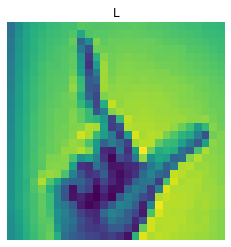

In [54]:
# clasificacion
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K' , 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', ' X ',' Y ']
# imagen al azar
i = random.randint(1,27455)
plt.imshow(train_set[i,1:].reshape((28,28))) 
plt.imshow(train_set[i,1:].reshape((28,28))) 
label_index = train["label"][i]
plt.title(f"{labels[label_index]}")
plt.axis('off')
"""
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()"""

## 3. Examine the dataset
<p>Let's examine how many images of each letter can be found in the dataset.</p>
<p>Remember that dataset has already been split into training and test sets for you, where <code>x_train</code> and <code>x_test</code> contain the images, and <code>y_train</code> and <code>y_test</code> contain their corresponding labels.</p>
<p>Each entry in <code>y_train</code> and <code>y_test</code> is one of <code>0</code>, <code>1</code>, or <code>2</code>, corresponding to the letters <code>'A'</code>, <code>'B'</code>, and <code>'C'</code>, respectively.</p>
<p>We will use the arrays <code>y_train</code> and <code>y_test</code> to verify that both the training and test sets each have roughly equal proportions of each letter.</p>

In [55]:
#cantida de imagenes por clasificacion
num_A_train = sum(y_train==0)
num_B_train = sum(y_train==1)
num_C_train = sum(y_train==2)
num_D_train = sum(y_train==3)
num_E_train = sum(y_train==4)
num_F_train = sum(y_train==5)


num_A_test = sum(y_test==0)
num_B_test = sum(y_test==1)
num_C_test = sum(y_test==2)
num_D_test = sum(y_test==3)
num_E_test = sum(y_test==4)
num_F_test = sum(y_test==5)

from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 12345)
x_train = x_train.reshape(x_train.shape[0], *(28, 28, 1))
x_test = x_test.reshape(x_test.shape[0], *(28, 28, 1))
x_validate =x_validate.reshape(x_validate.shape[0], *(28, 28, 1))


# Print statistics about the dataset
print("Training set:")
print("\tA: {}, B: {}, C: {}, D: {}, E: {}, F: {}".format(num_A_train, num_B_train, num_C_train,num_D_train, num_E_train, num_F_train))
print("Test set:")
print("\tA: {}, B: {}, C: {}, D: {}, E: {}, F: {}".format(num_A_test, num_B_test, num_C_test,num_D_test, num_E_test, num_F_test))

Training set:
	A: 1126, B: 1010, C: 1144, D: 1196, E: 957, F: 1204
Test set:
	A: 331, B: 432, C: 310, D: 245, E: 498, F: 247


## 4. One-hot encode the data
<p>Currently, our labels for each of the letters are encoded as categorical integers, where <code>'A'</code>, <code>'B'</code> and <code>'C'</code> are encoded as <code>0</code>, <code>1</code>, and <code>2</code>, respectively.  However, recall that Keras models do not accept labels in this format, and we must first one-hot encode the labels before supplying them to a Keras model.</p>
<p>This conversion will turn the one-dimensional array of labels into a two-dimensional array.</p>
<p><img src="https://assets.datacamp.com/production/project_509/img/onehot.png" alt="one-hot encoding"></p>
<p>Each row in the two-dimensional array of one-hot encoded labels corresponds to a different image.  The row has a <code>1</code> in the column that corresponds to the correct label, and <code>0</code> elsewhere.  </p>
<p>For instance, </p>
<ul>
<li><code>0</code> is encoded as <code>[1, 0, 0]</code>, </li>
<li><code>1</code> is encoded as <code>[0, 1, 0]</code>, and </li>
<li><code>2</code> is encoded as <code>[0, 0, 1]</code>.</li>
</ul>

In [56]:
#no usado
"""from keras.utils import np_utils
# One-hot encode the training labels
y_train_OH = np_utils.to_categorical(y_train,25)

# One-hot encode the test labels
y_test_OH = np_utils.to_categorical(y_test,25)"""


## 5. Define the model
<p>Now it's time to define a convolutional neural network to classify the data.</p>
<p>This network accepts an image of an American Sign Language letter as input.  The output layer returns the network's predicted probabilities that the image belongs in each category.</p>

In [57]:
#definicion del modelo 
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

#redes neuronales
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), input_shape = (28,28,1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), input_shape = (28,28,1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), input_shape = (28,28,1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())

cnn_model.add(Dense(units = 512, activation = 'relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(units = 25, activation = 'softmax'))
cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 3, 3, 128)       

## 6. Compile the model
<p>After we have defined a neural network in Keras, the next step is to compile it! </p>

In [58]:
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam' ,metrics =['accuracy'])

## 7. Train the model
<p>Once we have compiled the model, we're ready to fit it to the training data.</p>

In [59]:
#Training the CNN model
history = cnn_model.fit(x_train, y_train, batch_size = 512, epochs = 50, verbose = 1, validation_data = (x_validate, y_validate))

Train on 21964 samples, validate on 5491 samples
Epoch 1/50
21964/21964 [==============================] - 23s 1ms/step - loss: 3.1747 - accuracy: 0.0529 - val_loss: 3.1060 - val_accuracy: 0.1007
Epoch 2/50
21964/21964 [==============================] - 19s 863us/step - loss: 2.7927 - accuracy: 0.1449 - val_loss: 2.3625 - val_accuracy: 0.2653
Epoch 3/50
21964/21964 [==============================] - 19s 875us/step - loss: 2.1488 - accuracy: 0.3040 - val_loss: 1.6727 - val_accuracy: 0.4915
Epoch 4/50
21964/21964 [==============================] - 19s 887us/step - loss: 1.6082 - accuracy: 0.4638 - val_loss: 1.1408 - val_accuracy: 0.6613
Epoch 5/50
21964/21964 [==============================] - 18s 841us/step - loss: 1.1954 - accuracy: 0.5901 - val_loss: 0.7902 - val_accuracy: 0.7565
Epoch 6/50
21964/21964 [==============================] - 18s 820us/step - loss: 0.9304 - accuracy: 0.6744 - val_loss: 0.5825 - val_accuracy: 0.8239
Epoch 7/50
21964/21964 [==============================] - 2

## 8. Test the model
<p>To evaluate the model, we'll use the test dataset.  This will tell us how the network performs when classifying images it has never seen before!</p>
<p>If the classification accuracy on the test dataset is similar to the training dataset, this is a good sign that the model did not overfit to the training data.  </p>

Text(0.5, 1.0, 'Accuracy evolution')

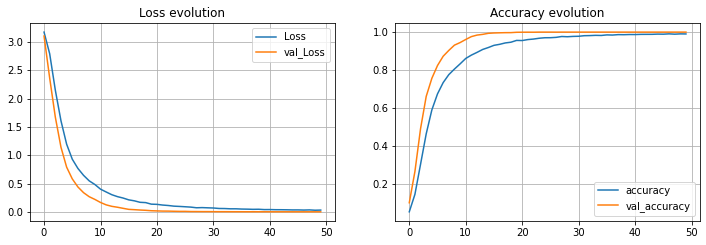

In [61]:
#la precision del entrenamiento a lo largo del tiempo
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

In [62]:
predicted_classes = cnn_model.predict_classes(X_test)

## 9. Visualize mistakes
<p>Hooray!  Our network gets very high accuracy on the test set!  </p>
<p>The final step is to take a look at the images that were incorrectly classified by the model.  Do any of the mislabeled images look relatively difficult to classify, even to the human eye?  </p>
<p>Sometimes, it's possible to review the images to discover special characteristics that are confusing to the model.  However, it is also often the case that it's hard to interpret what the model had in mind!</p>

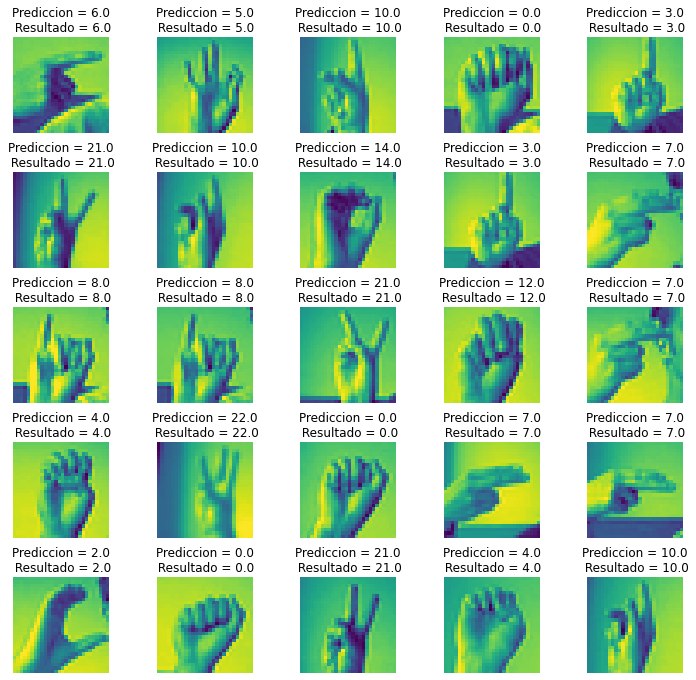

In [69]:
#prueva con matris de 5 x 5
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i].reshape(28,28))
    axes[i].set_title(f"Prediccion = {predicted_classes[i]:0.1f}\n Resultado = {y_test[i]:0.1f}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)